In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from tqdm import tqdm
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm_notebook
from scipy.optimize import curve_fit
from tsmoothie.smoother import LowessSmoother
import matplotlib
from statsmodels.tsa.stattools import acf, pacf
import mpl_interactions.ipyplot as iplt
from sklearn.metrics import r2_score
from scipy.stats import linregress

In [2]:
def psi(m, b):
    return (1/10) * b**(-1/10) * m**(-0.9)

def cumulativeM(m, b):
    return b**(-0.1) * m**(0.1)

def inverseCumM(u, b):
    return b * u**(10)

In [3]:
def pdfLogSpace(x, xb, gamma, h):
    return 2*gamma * np.exp(x + gamma*(np.exp(xb) - 2*np.exp(x)) + (gamma * (h - 1) - 1)*np.log(2 * np.exp(x) + h) + np.log(1 + 2*np.exp(x)) -\
                            gamma*(h - 1)*np.log(h + np.exp(xb)))


def cdfLogSpace(x, xb, gamma, h):
    return 1  - np.exp((-2*np.exp(x) + np.exp(xb))*gamma) * ((2*np.exp(x) + h)**((-1 + h) * gamma))*((np.exp(xb) + h)**(gamma - h*gamma))


def  drawCDF(unif, gamma, xb, h):
    #if np.sign(cdfLogSpace(-100, gamma = gamma, xb = xb) - unif) * np.sign(cdfLogSpace(50, gamma = gamma, xb = xb) - unif) == 1:
        #print(gamma, xb, unif, cdfLogSpace(-200, gamma = gamma, xb = xb) - unif, cdfLogSpace(50, gamma = gamma, xb = xb) - unif)
    return root_scalar(lambda t: cdfLogSpace(t, gamma = gamma, xb = xb, h = h) - unif, bracket=[-400, 50], method='brentq').root

In [4]:
criticalPoint = 1 / np.log(2)
halfGammaGammaC = np.abs(np.logspace(np.log10(np.abs(1 - criticalPoint)), np.log10(.1), 50))
gammaAbove = halfGammaGammaC + criticalPoint
gammaBelow = - halfGammaGammaC  + criticalPoint
gammaValues = np.concatenate((gammaBelow, gammaAbove[::-1]))
gammaGammaC = np.concatenate((halfGammaGammaC, halfGammaGammaC[::-1]))

In [5]:
def sizeAtBirth(gamma, xb0, h, seriesLength = 5000):
    uniformDraws = np.random.uniform(size = seriesLength)

    logSizes = np.zeros(seriesLength)
    logSizes[0] = xb0
    for i in range(1, seriesLength):
        logSizes[i] = drawCDF(unif = uniformDraws[i], gamma = gamma, xb = logSizes[i-1], h = h)

    return logSizes

In [6]:
nTrajectoires = 50

b = 10

pointsPerTrajectoiry = 5000

h = .05

simulate = False
if simulate:
    startingPointsUniform = np.random.uniform(0, 1, nTrajectoires * 10)
    startingPoints = inverseCumM(startingPointsUniform, b)
    aCorrValues = np.zeros((len(gammaValues), pointsPerTrajectoiry ))
    allSizes = np.zeros((len(gammaValues), nTrajectoires * 50 * 10))
    for j, gamma in enumerate(tqdm_notebook([gammaValues[0]])):
        sizes = np.zeros(nTrajectoires * 50 * 10)
        #print(sizes.shape)
        for i in range(nTrajectoires):
            for t in range(10):
                logSizes = sizeAtBirth(gamma = gamma, xb0 = np.log(startingPoints[10 * i + t]), seriesLength=pointsPerTrajectoiry, h = h)
                #print((50 * i * 10) + 50*t,(50 * i * 10) + 50*(t + 1))
                sizes[(50 * i * 10) + 50*t:(50 * i * 10) + 50*(t + 1)] += np.array([logSizes[l] for l in np.linspace(400, 4999, 50).astype(int)]) 
                aCorr = acf(np.exp(logSizes), fft = True, nlags = pointsPerTrajectoiry - 1)
                autocorrelation = acf(np.exp(logSizes), fft = True, nlags = pointsPerTrajectoiry - 1)
                aCorrValues[j, :] += autocorrelation / (nTrajectoires * 10)
        allSizes[j, :] = sizes

    
    #np.save("../data/sizeAtBirthShortPositiveH.npy", allSizes)
    #np.save("../data/aCorrValuesShortPositiveH.npy", aCorrValues)
    

In [8]:
! ls ../../

README.md code      data


In [10]:
allSizes = np.load("../../data/positiveH/sizeAtBirthShortPositiveH.npy")
aCorrValues = np.load("../../data/positiveH/aCorrValuesShortPositiveH.npy")

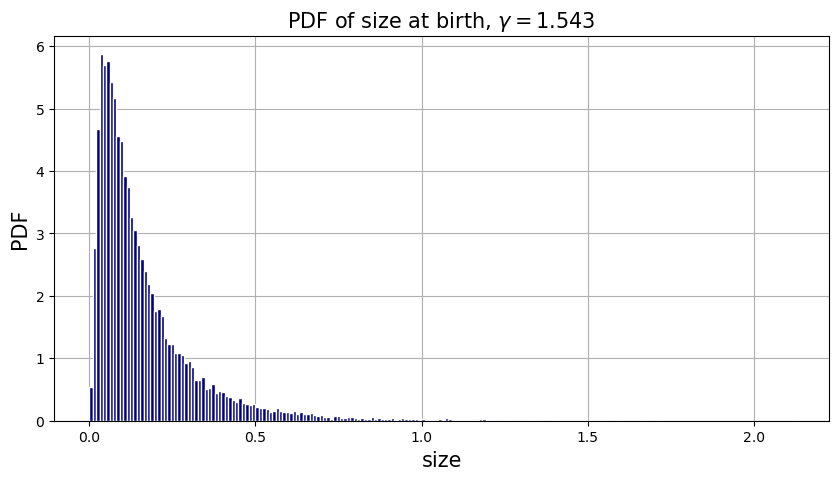

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.hist(np.exp(allSizes[50,:]), bins = 'fd', density = 'True', color = 'navy', edgecolor = 'white', zorder = 2)
ax.set_ylabel('PDF', fontsize = 15)
ax.set_xlabel('size', fontsize = 15)
ax.set_title(f'PDF of size at birth, $\gamma = {gammaValues[50]:.3f}$', fontsize = 15)
ax.grid(zorder = 1)
plt.show()

In [14]:
def powerLaw(x, a, b):
    return a*x**b

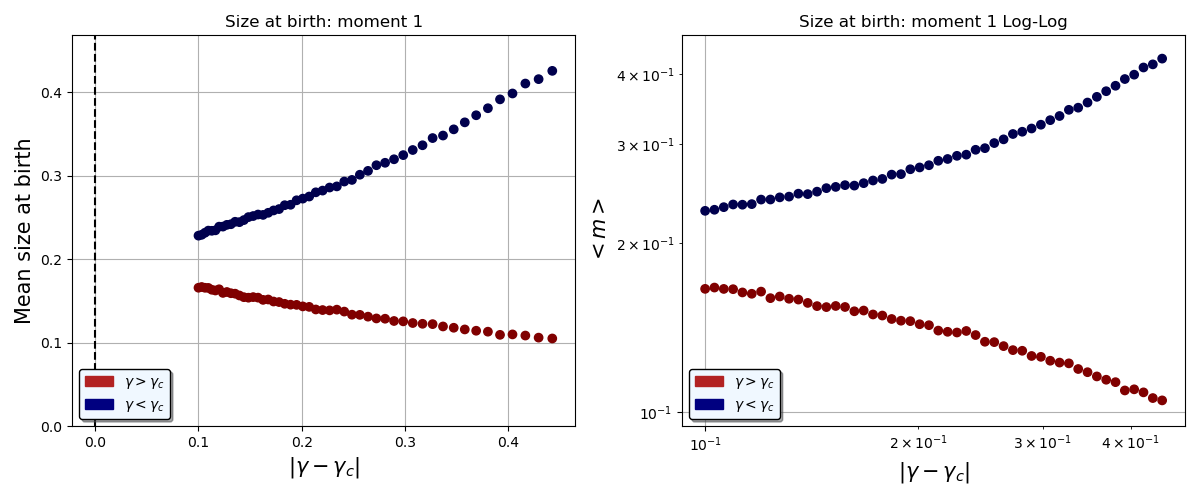

In [17]:
#omega2BelowCritical = omega2Values[omega2Values < criticalPoint]
%matplotlib ipympl
import matplotlib.patches as mpatches
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax1  = plt.subplots(1,2, figsize = (12, 5))
ax, ax_ = ax1.flatten()

#meanSizesAtBirth = np.load(f'../data/meanSizeBirth20000SingleTraitSamplingM.npy')

colIdx = np.where(gammaValues < criticalPoint, 0, 1)

def fY (x, k):
    title1 = f'Size at birth: moment {k}'
    ax.set_title(title1)
    yArr = np.exp(allSizes)**k
    
    y = np.mean(yArr, axis = 1)
    
    ax.set_ylim(top = 1.1*np.max(y))
    return y

controls = iplt.scatter(gammaGammaC, fY, k = [1, 2, 3, 4, 5, 6], c= colIdx, zorder = 3, ax = ax, cmap = 'seismic')

#ax.scatter(gammaValues  - criticalPoint, meanSizesAtBirth , color = 'navy', zorder = 2)

xAxis = np.linspace(np.min(gammaGammaC), np.max(gammaGammaC), 100)

#ax.plot(xAxis - criticalPoint, powerLaw(xAxis, *popt), label = f'Power law fit: $a = {popt[0]:.3}$, $b = {popt[1]:.3}$')
#ax.axvline(absorbingValue - criticalPoint, color = 'red', linestyle = '--', zorder = 2)
ax.axvline(0, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)
ax.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15, zorder = 2)
ax.set_ylabel('Mean size at birth', fontsize = 15, zorder = 2)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'upper right')
#ax.set_title('Mean size at birth for different size of the system', fontsize = 15)
ax.grid(zorder = 1)
powerLawValues = {'1':(0.5, 1), '2': (0.15, 1), '3': (0.1, 1) , '4':(0.08, 1), '5':(0.1, 1), '6':(0.1 , 1)}
def fY2 (x, k):
    title2 = f'Size at birth: moment {k} Log-Log'
    ax_.set_title(title2)
    yArr2 = np.exp(allSizes)**k
    y2 = np.mean(yArr2, axis = 1)
    ax_.set_ylim(bottom = 0.9 * np.min(y2), top = 1.1*np.max(y2))
    return y2


def fY3 (x, k):
    y3 = powerLaw(xAxis,*powerLawValues[str(int(k))])
    return y3


#ax_.plot(xAxis, powerLaw(xAxis,*powerLawValues[str(int(k))]), color = 'red', label = f'm = {k} line', zorder = 4)
_ = iplt.scatter(gammaGammaC, fY2, controls=controls, ax = ax_, zorder = 3, c = colIdx, cmap = 'seismic')

red_patch = mpatches.Patch(color='firebrick', label='$\gamma > \gamma_c$', hatch = '.')
blue_patch = mpatches.Patch(color='navy', label='$\gamma < \gamma_c$', hatch = '.')
ax.legend(handles=[red_patch, blue_patch], facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'lower left')
#_ = iplt.plot(xAxis, fY3, controls=controls, color = 'red', ax = ax_, zorder = 3, label = 'Power law comparison')

ax_.set_xscale('log')
ax_.set_yscale('log')
#ax_.scatter(gammaValues, sizeBirth20000.mean(axis = 1), zorder = 2, color = 'navy')
ax_.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15)
ax_.set_ylabel('$<m>$', fontsize = 15)
ax_.grid(zorder = 1)
#ax_.axvline(criticalPoint, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)

#ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
#ax_.set_title('Mean size at birth for different generations, $log-log$')
ax_.legend(handles=[red_patch, blue_patch], facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'lower left')
fig.tight_layout()
plt.show()

In [18]:
def autoCorrelationFunc(t, xi, n_c):
    return t**(-xi) * np.exp(-t/n_c)

In [19]:
corrLengths = np.zeros(len(gammaValues))
exponentN = np.zeros(len(gammaValues))
for i in tqdm_notebook(range(len(gammaValues))):
    autocorrelation = aCorrValues[i,:]
    #ax.plot(list(range(len(autocorrelation))), autocorrelation, label = f'Generation {i}')
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    corrLengths[i] = popt[1]
    exponentN[i] = popt[0]


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Normalized $acf$')

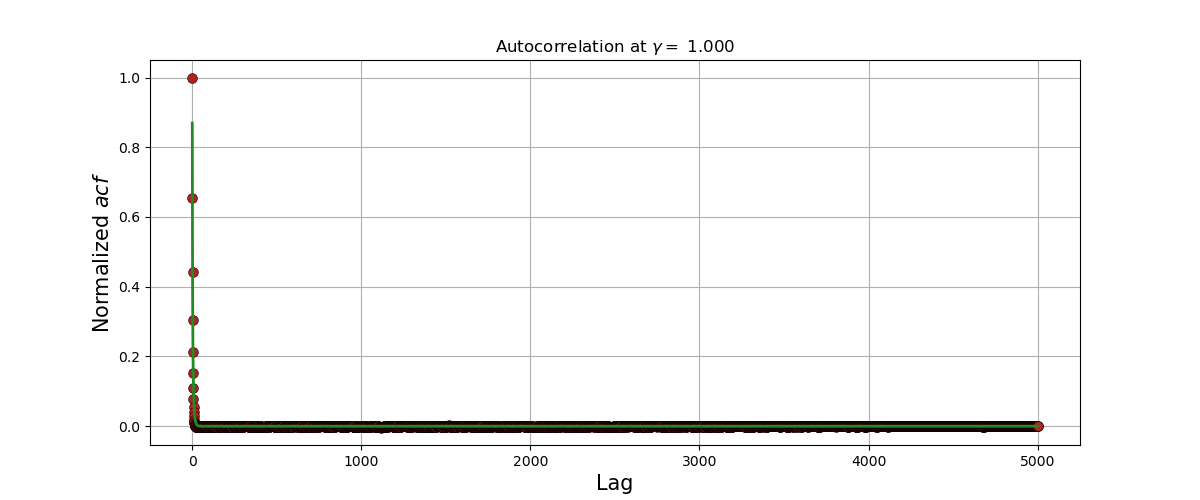

In [20]:
%matplotlib ipympl
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
def fY (x, gamma):
    global title 
    title = f'Autocorrelation at $\\gamma = $ {gamma:.3f}'
    ax.set_title(title)
    idxGamma = list(gammaValues).index(gamma)
    autocorrelation = aCorrValues[idxGamma]
    return autocorrelation

def fY2 (x, gamma):
    idxGamma = list(gammaValues).index(gamma)
    autocorrelation = aCorrValues[idxGamma]
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
  
    return autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt)


controls = iplt.scatter(range(1, 5001), fY, gamma = gammaValues, edgecolor = 'black', s = 50, zorder = 2, color = 'firebrick',\
                         linewidth = 0.4)

_ = iplt.plot(range(1, 5001), fY2, controls=controls, color = 'forestgreen', linewidth = 2)
ax.grid(zorder = 1)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Normalized $acf$', fontsize = 15)


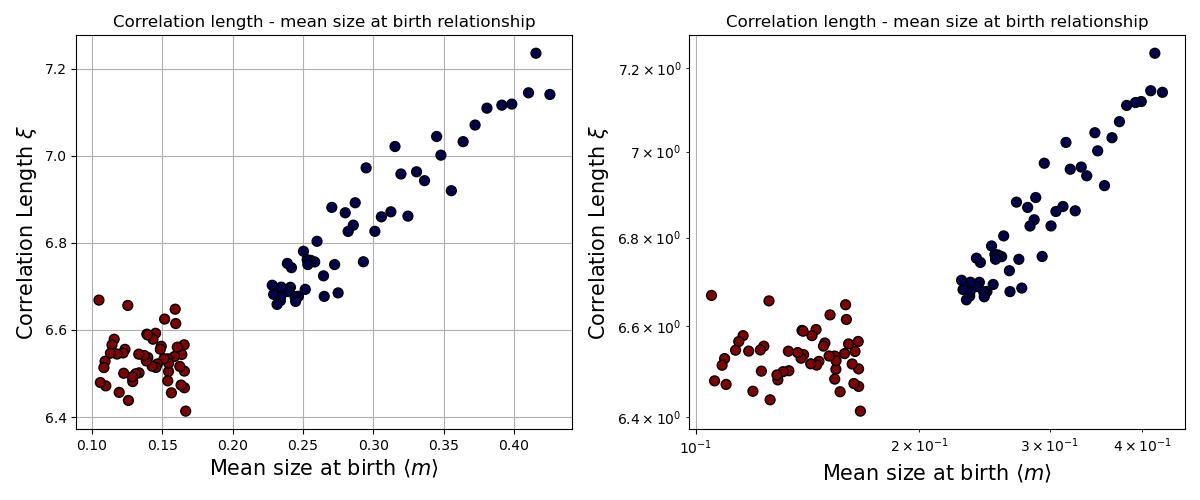

In [21]:
fig, ax_ = plt.subplots(1, 2, figsize = (12, 5))

meanSizesAtBirth = np.mean(np.exp(allSizes), axis = 1)
for ax, axis in zip(ax_.flatten(), ['linear', 'log']):
    ax.scatter(meanSizesAtBirth, corrLengths, edgecolor = 'black', s = 50, zorder = 2, c = colIdx, cmap = 'seismic')
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('Mean size at birth $\\langle m \\rangle$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 12)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
fig.tight_layout()
#ax_[1].plot(np.linspace(0.01, 0.3, 1000), powerLaw(np.linspace(0.01, 0.3, 1000), 2.8, -1), color = 'red')
#ax2 = ax_[0].inset_axes([0.3, 0.3, 0.6, 0.6])
#ax2.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)

Text(0.5, 1.0, 'Correlation length approaching the critical point')

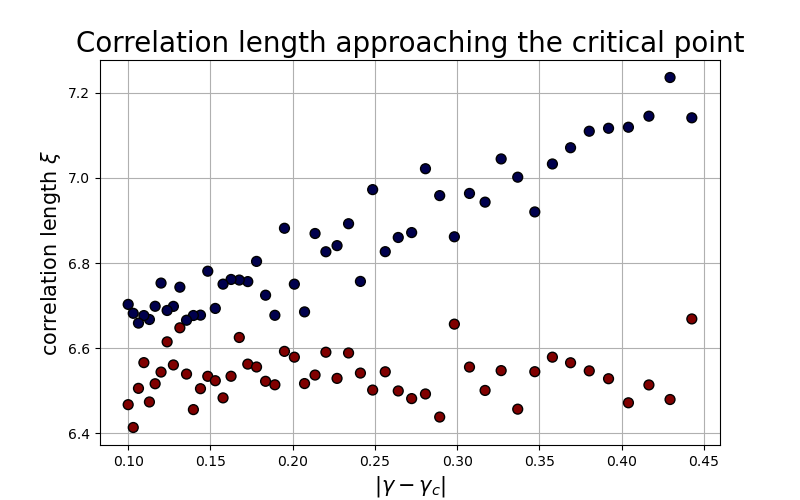

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(gammaGammaC, corrLengths, edgecolor = 'black', s = 50, zorder = 2, c = colIdx, cmap = 'seismic')
#ax.set_ylim(top = 500, bottom = -1)
ax.grid(zorder = 1)
ax.set_xlabel('$|\\gamma - \\gamma_c|$', fontsize = 15)
ax.set_ylabel('correlation length $\\xi$', fontsize = 15)
ax.set_title('Correlation length approaching the critical point', fontsize = 20)


Text(0.5, 1.0, 'Exponent $\\eta$ approaching the critical point')

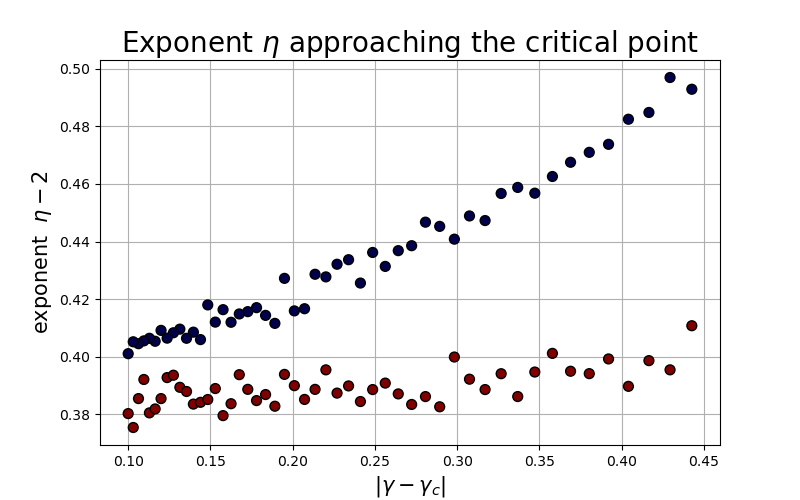

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(gammaGammaC, exponentN, edgecolor = 'black', s = 50, zorder = 2, c = colIdx, cmap = 'seismic')
#ax.set_ylim(bottom = bottom,top = top)
ax.grid(zorder = 1)
ax.set_xlabel('$|\\gamma - \\gamma_c|$', fontsize = 15)
ax.set_ylabel('exponent  $\\eta - 2$', fontsize = 15)
ax.set_title('Exponent $\\eta$ approaching the critical point', fontsize = 20)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
from scipy.signal import detrend
sig_fft = fftpack.fft(detrend(autocorrelation))

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The return the corresponding frequencies
sample_freq = fftpack.fftfreq(len(autocorrelation), d = 1)
ax.plot(sample_freq, power)
ax.set_xlim(left = 0)
